https://www.allesfitter.com/allesclass/retriving-data-and-models

## stellar parameters

In [1]:
import pandas as pd

with pd.HDFStore('../vespa/mist_starmodel_single.h5') as hdf:
    print(hdf.keys())

['/samples', '/obs/df']


In [2]:
import pandas as pd
import numpy as np

samples = pd.read_hdf('../vespa/mist_starmodel_single.h5', key='samples')
samples = samples.rename({
    'radius_0_0': 'radius',
    'mass_0_0': 'mass',
    'Teff_0_0': 'Teff',
    'logg_0_0': 'logg',
    'feh_0': 'feh',
    
}, axis=1)

aurstar = samples['radius'].std() 
mstar = samples['mass'].median() 
umstar = samples['mass'].std() 

teff = samples['Teff'].median()
uteff = samples['Teff'].std()
logg = samples['logg'].median()
ulogg = samples['logg'].std()
feh = samples['feh'].median()
ufeh = samples['feh'].std()

for p in ['radius', 'mass', 'Teff', 'logg', 'feh', 'AV_0']:
    x = samples[p].median() 
    y = samples[p].std() 
    print(f'{p}={x:.2f}+/-{y:.2f}')

radius=0.28+/-0.00
mass=0.27+/-0.01
Teff=3291.18+/-47.12
logg=4.97+/-0.01
feh=0.05+/-0.05
AV_0=0.32+/-0.14


## retrieving data and models

### tess

In [3]:
import os
import pickle
import gzip
from allesfitter import config as config_tess

datadir = '../allesfitter/tess'
config_tess.init(datadir)
f = gzip.GzipFile(os.path.join(config_tess.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_tess = pickle.load(f)
f.close()

results_tess.keys(), len(results_tess)


! WARNING:
 Module "rebound" could not be imported. Orbital plots are not available.
type: <class 'UserWarning'>, file: /home/jp/miniconda3/envs/allesfitter/lib/python3.6/site-packages/allesfitter/plot_top_down_view.py, line: 39


Filling the Basement


allesfitter version
---------------------
v1.2.4

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 1816.697705999948
	shifted epoch: 1829.201280999948
	shifted by 5 periods


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [4]:
instruments = config_tess.BASEMENT.fulldata.keys()
instruments

dict_keys(['tess'])

In [5]:
results_tess['samples'].shape

(24798, 10)

In [6]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess)
posterior_samples_tess.shape

(24798, 10)

In [8]:
posterior_params_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess, as_type='dic') # all weighted posterior_samples
posterior_params_median_tess, posterior_params_ll_tess, posterior_params_ul_tess = general_output.get_params_from_samples(posterior_samples_tess)

In [33]:
import allesfitter
import numpy as np

#::: your settings
inst = 'tess' 
key = 'flux' 

#::: initialize the allesclass
af_tess = allesfitter.allesclass(datadir)

df = {}
df[inst] = {}

#::: load the data (and the correct error bars)
df[inst]['time'] = af_tess.data[inst]['time']+2457000
df[inst]['flux'] = af_tess.data[inst][key]
df[inst]['flux_err'] = af_tess.data[inst]['err_scales_'+key] * af_tess.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model


df[inst]['baseline'] = af_tess.get_posterior_median_baseline(inst, key)
df[inst]['model'] = af_tess.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df[inst]['detrended_flux'] = df[inst]['flux']-df[inst]['baseline']
df[inst]['residuals'] = df[inst]['flux']-(df[inst]['model']+df[inst]['baseline'])

#::: save everything to a file for your collaborators
# X = np.column_stack((time, flux, flux_err, detrended_flux, model, residuals))
# np.savetxt('my_final_file.csv', X, delimiter=',')

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.4

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 1816.697705999948
	shifted epoch: 1829.201280999948
	shifted by 5 periods


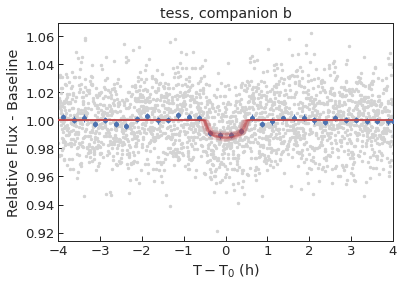

In [34]:
fig, ax = af_tess.plot(inst, 'b', 'phasezoom', Nsamples=50, force_binning=True)

In [35]:
fig.savefig('../allesfitter/tess/tess_folded_allesfitter.pdf', bbox_inches='tight')

Text(0.5, 0.98, '$TESS$')

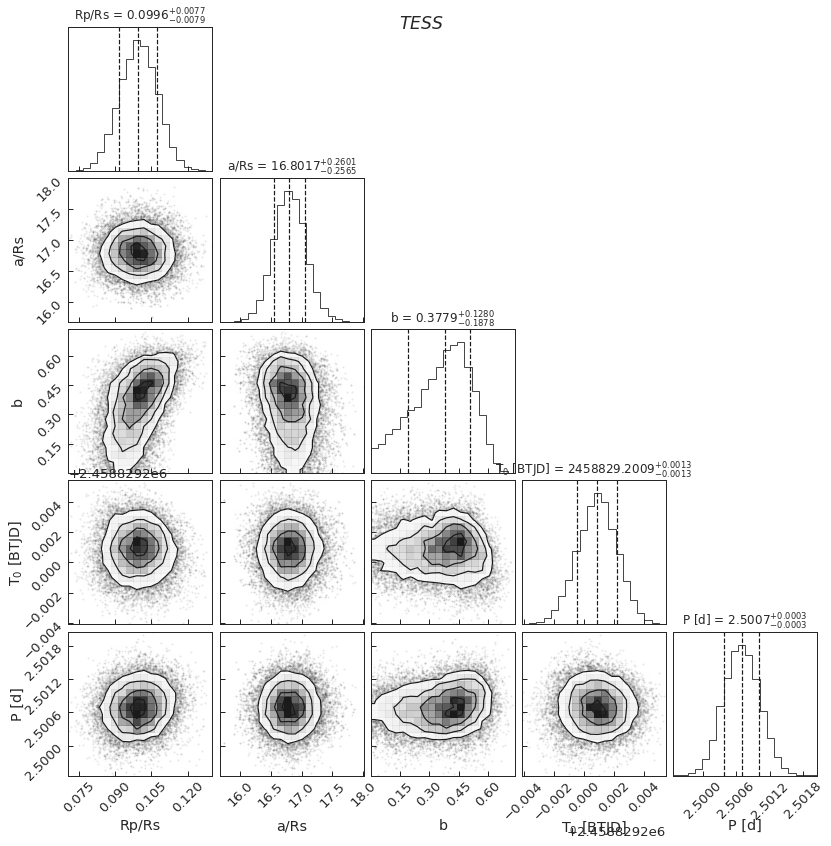

In [36]:
import corner
import pandas as pd

df_samples_tess = pd.DataFrame.from_dict(posterior_params_tess)
df_samples_tess.head()
df_samples_tess['b_epoch'] = df_samples_tess['b_epoch']+2457000

df_samples_tess['aRs'] = 1/df_samples_tess['b_rsuma']
df_samples_tess['inc'] = np.rad2deg(np.arccos(df_samples_tess['b_cosi']))
df_samples_tess['imp_par'] = df_samples_tess['b_cosi']*df_samples_tess['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig = corner.corner(df_samples_tess[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig.suptitle('$TESS$')

In [37]:
fig.savefig('../paper/figures/transit_corner_tess.png', bbox_inches='tight')

In [38]:
df[inst]['posterior_samples'] = df_samples_tess

<AxesSubplot:>

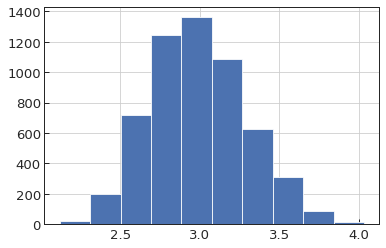

In [39]:
import astropy.units as u

Rp = df['tess']['posterior_samples'].b_rr*samples.radius*u.Rsun.to(u.Rearth)
Rp.hist()

In [40]:
import flammkuchen as dd

dd.save('../allesfitter/tess/allesfit_transit_results.h5', df)

## derived params

In [41]:
import flammkuchen as dd

df = dd.load('../allesfitter/tess/allesfit_transit_results.h5')

In [42]:
df_samples = df['tess']['posterior_samples']

### Teq

In [43]:
Rs = samples['radius']
Teff = samples['Teff']
aRs = np.random.choice(df_samples['aRs'], len(Rs))
Teq_samples = (Teff * np.sqrt(Rs / (2 * aRs)))
Teq_samples.median(), Teq_samples.std()

(300.7279831305834, 4.153574734380088)

## plots

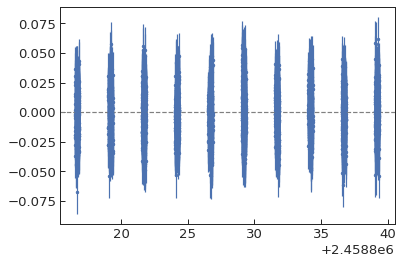

In [46]:
import matplotlib.pyplot as pl

inst = 'tess'
key = 'flux'
time = af_tess.data[inst]['time']+2457000
flux = af_tess.data[inst][key]
flux_err = af_tess.data[inst]['err_scales_'+key] * af_tess.posterior_params_median['err_'+key+'_'+inst]

baseline = af_tess.get_posterior_median_baseline(inst, key)
model = af_tess.get_posterior_median_model(inst, key)
pl.errorbar(time, flux-(model+baseline), flux_err, fmt='b.')
pl.axhline(0, color='grey', linestyle='--')

In [47]:
import lightkurve as lk

lc = lk.LightCurve(time=df[inst]['time'], 
                     flux=df[inst]['flux'], 
                     flux_err=df[inst]['flux_err'])

In [48]:
period = df_samples['b_period'].median()
t0 = df_samples['b_epoch'].median()


! WARNING:
 "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
type: <class 'lightkurve.utils.LightkurveDeprecationWarning'>, file: /home/jp/miniconda3/envs/allesfitter/lib/python3.6/site-packages/astropy/utils/decorators.py, line: 535


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

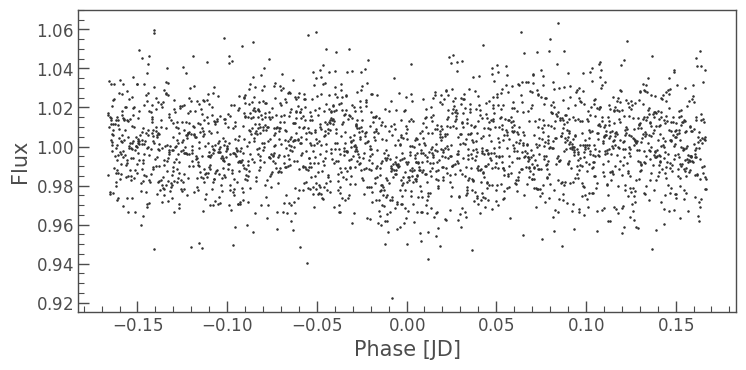

In [49]:
fold = lc.fold(period=period, t0=t0)
fold.scatter()

Save phase-folded lc for vespa; See also vespa/download_folded_lc_from_allesfitter.py

In [50]:
phase_lim = 0.1

fp = 'tess_folded.csv'
columns_to_save = ['time', 'flux', 'flux_err']
df = fold.to_pandas().reset_index()[columns_to_save]
#trim only around the transit
idx = (df.time>-phase_lim) & (df.time<phase_lim)
df_trim = df[idx]
# df_trim.to_csv(fp, sep=' ', header=False, index=False)
df_trim

,time,flux,flux_err
454,-0.099753,1.016713,0.019018
455,-0.099654,0.991126,0.018979
456,-0.099603,1.009842,0.019106
457,-0.099574,0.988504,0.018865
458,-0.099127,1.001944,0.019116
...,...,...,...
1850,0.099478,0.999555,0.018979
1851,0.099604,1.003419,0.018972
1852,0.099678,0.998694,0.019972
1853,0.099722,0.975264,0.018906
